In [1]:
# import packages
import cftime
import gc
import glob
import intake
import sys

import cartopy as cy
import cartopy.crs as ccrs
import cmcrameri.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.stats import norm


ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/c/cowherd/.conda/envs/e3smeval/share/proj failed


In [2]:
import xarray as xr

from params import savepath, homedir, allnames
plt.style.use('science.mplstyle')
mpl.rcParams['axes.linewidth'] = 1

allnames2 = ['ACCESS-CM2',
 'BCC-CSM2-MR',
 'CESM2-WACCM',
 'GFDL-ESM4',
 'GFDL-CM4',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']


filenames = [f'{savepath}categs_{model}_ssp245.nc' for model in allnames2]
ds_245 = xr.open_mfdataset(filenames, combine='nested', concat_dim='model_id')
filenames = [f'{savepath}categs_{model}_ssp585.nc' for model in allnames2]
ds_585 = xr.open_mfdataset(filenames, combine='nested', concat_dim='model_id')


In [3]:
## prep a nice dictionary with the conditions included in a format that is nice

sddata = {}
for dr_t in ['all','dry','warm','warmdry','swei']:
    sddata[dr_t] = {}
    for exp in ['ssp245','ssp585']:
        sddata[dr_t][exp] = {}
        for model in allnames2:
            sddata[dr_t][exp][model] = {}


for exp in['ssp245', 'ssp585']:
    sddata[exp] = {}
    for model in allnames2:
        sddata[exp][model] = {}
        swei = xr.open_dataset(f'{savepath}swei_max_{model}_{exp}.nc') #swei_datasets_maxsnw[f'{model}_{exp}']
        categ = xr.open_dataset(f'{savepath}categs_{model}_{exp}.nc')
        swei_cond = categ['swei_cond']
        pr_cond = categ['pr_cond']
        tas_cond = categ['tas_cond']
        
        '''if exp == 'ssp245':
            swei_cond = ds_245['swei_cond'][name].values
            pr_cond = ds_245['pr_cond'][name].values
            tas_cond = ds_245['tas_cond'][name].values
        if exp == 'ssp585':
            swei_cond = ds_585['swei_cond'][name].values
            pr_cond = ds_585['pr_cond'][name].values
            tas_cond = ds_585['tas_cond'][name].values'''
        sddata['all'][exp][model] = swei_cond
        sddata['dry'][exp][model] = swei_cond & pr_cond & ~tas_cond
        sddata['warm'][exp][model] = swei_cond & ~pr_cond & tas_cond
        sddata['warmdry'][exp][model] = swei_cond & pr_cond & tas_cond
        sddata['swei'][exp][model] = swei

    

In [4]:
## use this
def get_highest_month(ds,var = 'snw'):
    tmp = ds[var].data.reshape(-1,12,ds[var].shape[1],ds[var].shape[2])
    highest_month = np.argmax(tmp, axis=1)
    coords = {'year': np.unique(ds.time.dt.year), 'lat' : ds.lat, 'lon' : ds.lon}
    data = xr.DataArray(highest_month, dims=('year', 'lat','lon'), coords=coords)
    return data

def convert_year_month(ds,var):
    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)
    data = ds[var].data.reshape(-1,12,160,320)
    # We then create a new dataset with year, month, lat, lon coordinates
    ds_new = xr.Dataset(
        {
            var: (("year", "month", "lat", "lon"), data),
        },
        coords={
            "year": years,
            "month": months,
            "lat": ds.lat,
            "lon": ds.lon,
        },
    )
    ds_new.attrs = ds.attrs
    return ds_new
    
## use this
def collapse_to_highest_month(ds, var, snw_ds, convert = True):
    highest_month = get_highest_month(snw_ds)
    if convert:
        ds = convert_year_month(ds, var)
    highest_month = highest_month.drop('lat')
    highest_month = highest_month.drop('lon')
    result = ds.sel(month=highest_month, method='nearest').drop('month')
    return result

## usethis
def get_3m_sum(data):
    rolling_sum = data.rolling(time = 3, min_periods=3).sum()
    return rolling_sum

def get_sd_categ(swei, pr, tas, attrs):
    swei_cond = swei < -0.8  # snow drought
    pr_cond = pr < 0  # dry 
    tas_cond = tas > 0  # warm
    
    ds_new = xr.Dataset(
        {
            "swei_cond": (("year", "lat", "lon"), swei_cond.swei.values),
            "pr_cond": (("year", "lat", "lon"), pr_cond.pr.values),
            "tas_cond": (("year", "lat", "lon"), tas_cond.tas.values),
        },
        coords={
            "year": pr.year,
            "lat": pr.lat,
            "lon": pr.lon,
        },
    )
    ds_new.attrs = attrs

    return ds_new
from scipy.stats import norm
def droughtindx(nsample):
    indx = []
    for i in range(nsample):
        px = (i+1-0.44)/(nsample+0.12)
        indx.append(norm.ppf(px))
    return indx


def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    

In [5]:

def get_swei(ds):
    swe = ds['snw']
    ntime = swe.shape[0]
    nlat = swe.shape[2]
    nlon = swe.shape[1]
    nyr = int(ntime / 12)
    nd = nlat * nlon
    nm = 12

    # Compute the 3-month cumulative sum for each pixel
    ds_cumsum = ds.rolling(time=3, min_periods=3).sum()

    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)

    # Reshape the data back into a 4D array of (year, month, lat, lon)
    ds_new = xr.DataArray(
        ds_cumsum.snw.data.reshape((-1, 12, ds.sizes['lat'], ds.sizes['lon'])),
        dims=('year', 'month', 'lat', 'lon'),
        coords={'year': years, 'month': months, 'lat': ds['lat'], 'lon': ds['lon']}
    )
    categ = np.zeros((nyr, nm, nlon, nlat))
    nsample = nyr
    sweix = droughtindx(nsample)  # all values for each pixel.
    sweix = np.array(sweix)

    aindx = np.argsort(ds_new.data, axis=0)

    # Create a broadcasting version of sweix
    sweix_broadcasted = sweix[:, np.newaxis, np.newaxis, np.newaxis]

    # Assign sorted sweix values to categ based on sorted indices (array, indices, values, axis)
    np.put_along_axis(categ, aindx,sweix_broadcasted, axis=0)

    # Create the new xarray Dataset
    ds_swei = xr.Dataset(
        {'swei':(('year','month','lat','lon'), categ)},
        coords={'year': years, 'month': months,'lat': ds['lat'], 'lon': ds['lon'], }
    )
    return ds_swei


In [6]:
scenarios = ['historical', 'ssp245', 'ssp585']
variables = ['snw', 'pr', 'tas']
datasets_3m_sum_maxsnw = {}
datasets_3m_sum = {}
swei_datasets = {}
swei_datasets_maxsnw = {}
categs = {}
for model in allnames2:
    filenames = [f"{savepath}{var}_{model}_{scen}.nc" for var in variables for scen in scenarios]
    datasets = {filename.split('/')[-1].split('.')[0]: xr.open_dataset(filename) for filename in filenames}
    for name, ds in datasets.items():
        datasets_3m_sum[name] = get_3m_sum(ds)

    for scen in scenarios[1:3]:
        ds_s = datasets[f'snw_{model}_{scen}']
        ds_h = datasets[f'snw_{model}_historical']
        ds_long = xr.concat([ds_h, ds_s], dim = 'time')
        swei_datasets[f'{model}_{scen}'] = get_swei(ds_long)

    for name, ds in datasets_3m_sum.items():
        var = name.split('_')[0]
        snw_ds = datasets_3m_sum[f'snw_{name.split(f"{var}_")[-1]}']
        datasets_3m_sum_maxsnw[name] = collapse_to_highest_month(ds, var, snw_ds, True)

    for name, ds in swei_datasets.items():
        var = 'swei'
        scen = name.split('_')[-1]
        snw_s = datasets_3m_sum[f'snw_{model}_{scen}']
        snw_h = datasets_3m_sum[f'snw_{model}_historical']
        snw_long = xr.concat([ds_h, ds_s], dim = 'time')
        tmp = collapse_to_highest_month(ds, var, snw_long, False)
        #tmp.to_netcdf(f'{savepath}swei_max_{name}.nc')
        swei_datasets_maxsnw[name] = tmp

    for name, swei in swei_datasets_maxsnw.items():
        scen = name.split('_')[-1]
        pr_h = datasets_3m_sum_maxsnw[f'pr_{model}_historical']
        pr_s = datasets_3m_sum_maxsnw[f'pr_{model}_{scen}']
        pr_long = xr.concat([pr_h, pr_s], dim = 'year')
        pr_anom = pr_long - pr_long.sel(year=slice(pr_long.year[0], pr_long.year[49])).mean(dim='year') ## val minus average

        tas_h = datasets_3m_sum_maxsnw[f'tas_{model}_historical']
        tas_s = datasets_3m_sum_maxsnw[f'tas_{model}_{scen}']
        tas_long = xr.concat([tas_h, tas_s], dim = 'year')
        tas_anom = tas_long - tas_long.sel(year=slice(tas_long.year[0], tas_long.year[49])).mean(dim='year') ## val minus average

        tmp = get_sd_categ(swei, pr_anom ,tas_anom, pr_long.attrs)
        #tmp.to_netcdf(f'{savepath}may3/categs_{name}.nc')
        categs[name] = tmp
        


In [7]:
snw = xr.open_dataset(savepath + 'snw_ACCESS-CM2_historical.nc')
is_snow = snw['snw'] > 0.3
freq_snow = np.nansum(is_snow, axis = 0) / 1980
snowmask = freq_snow > 0.1

In [8]:
## MASKS AND COORDS ## 
tmp = xr.open_dataset(savepath + '../snw_UKESM1-0-LL_historical.nc')
coord = [tmp['lat'],tmp['lon']]
landmask = xr.open_dataset(savepath + '../land_mask.nc')['mask'][0]
sftgif = xr.open_dataset(savepath + '../sftgif_rg.nc')
pct = sftgif['sftgif'][0][0]
icemask = pct < 5
landicemask = (icemask.values & landmask.values)
landicesnowmask = (snowmask & landicemask)

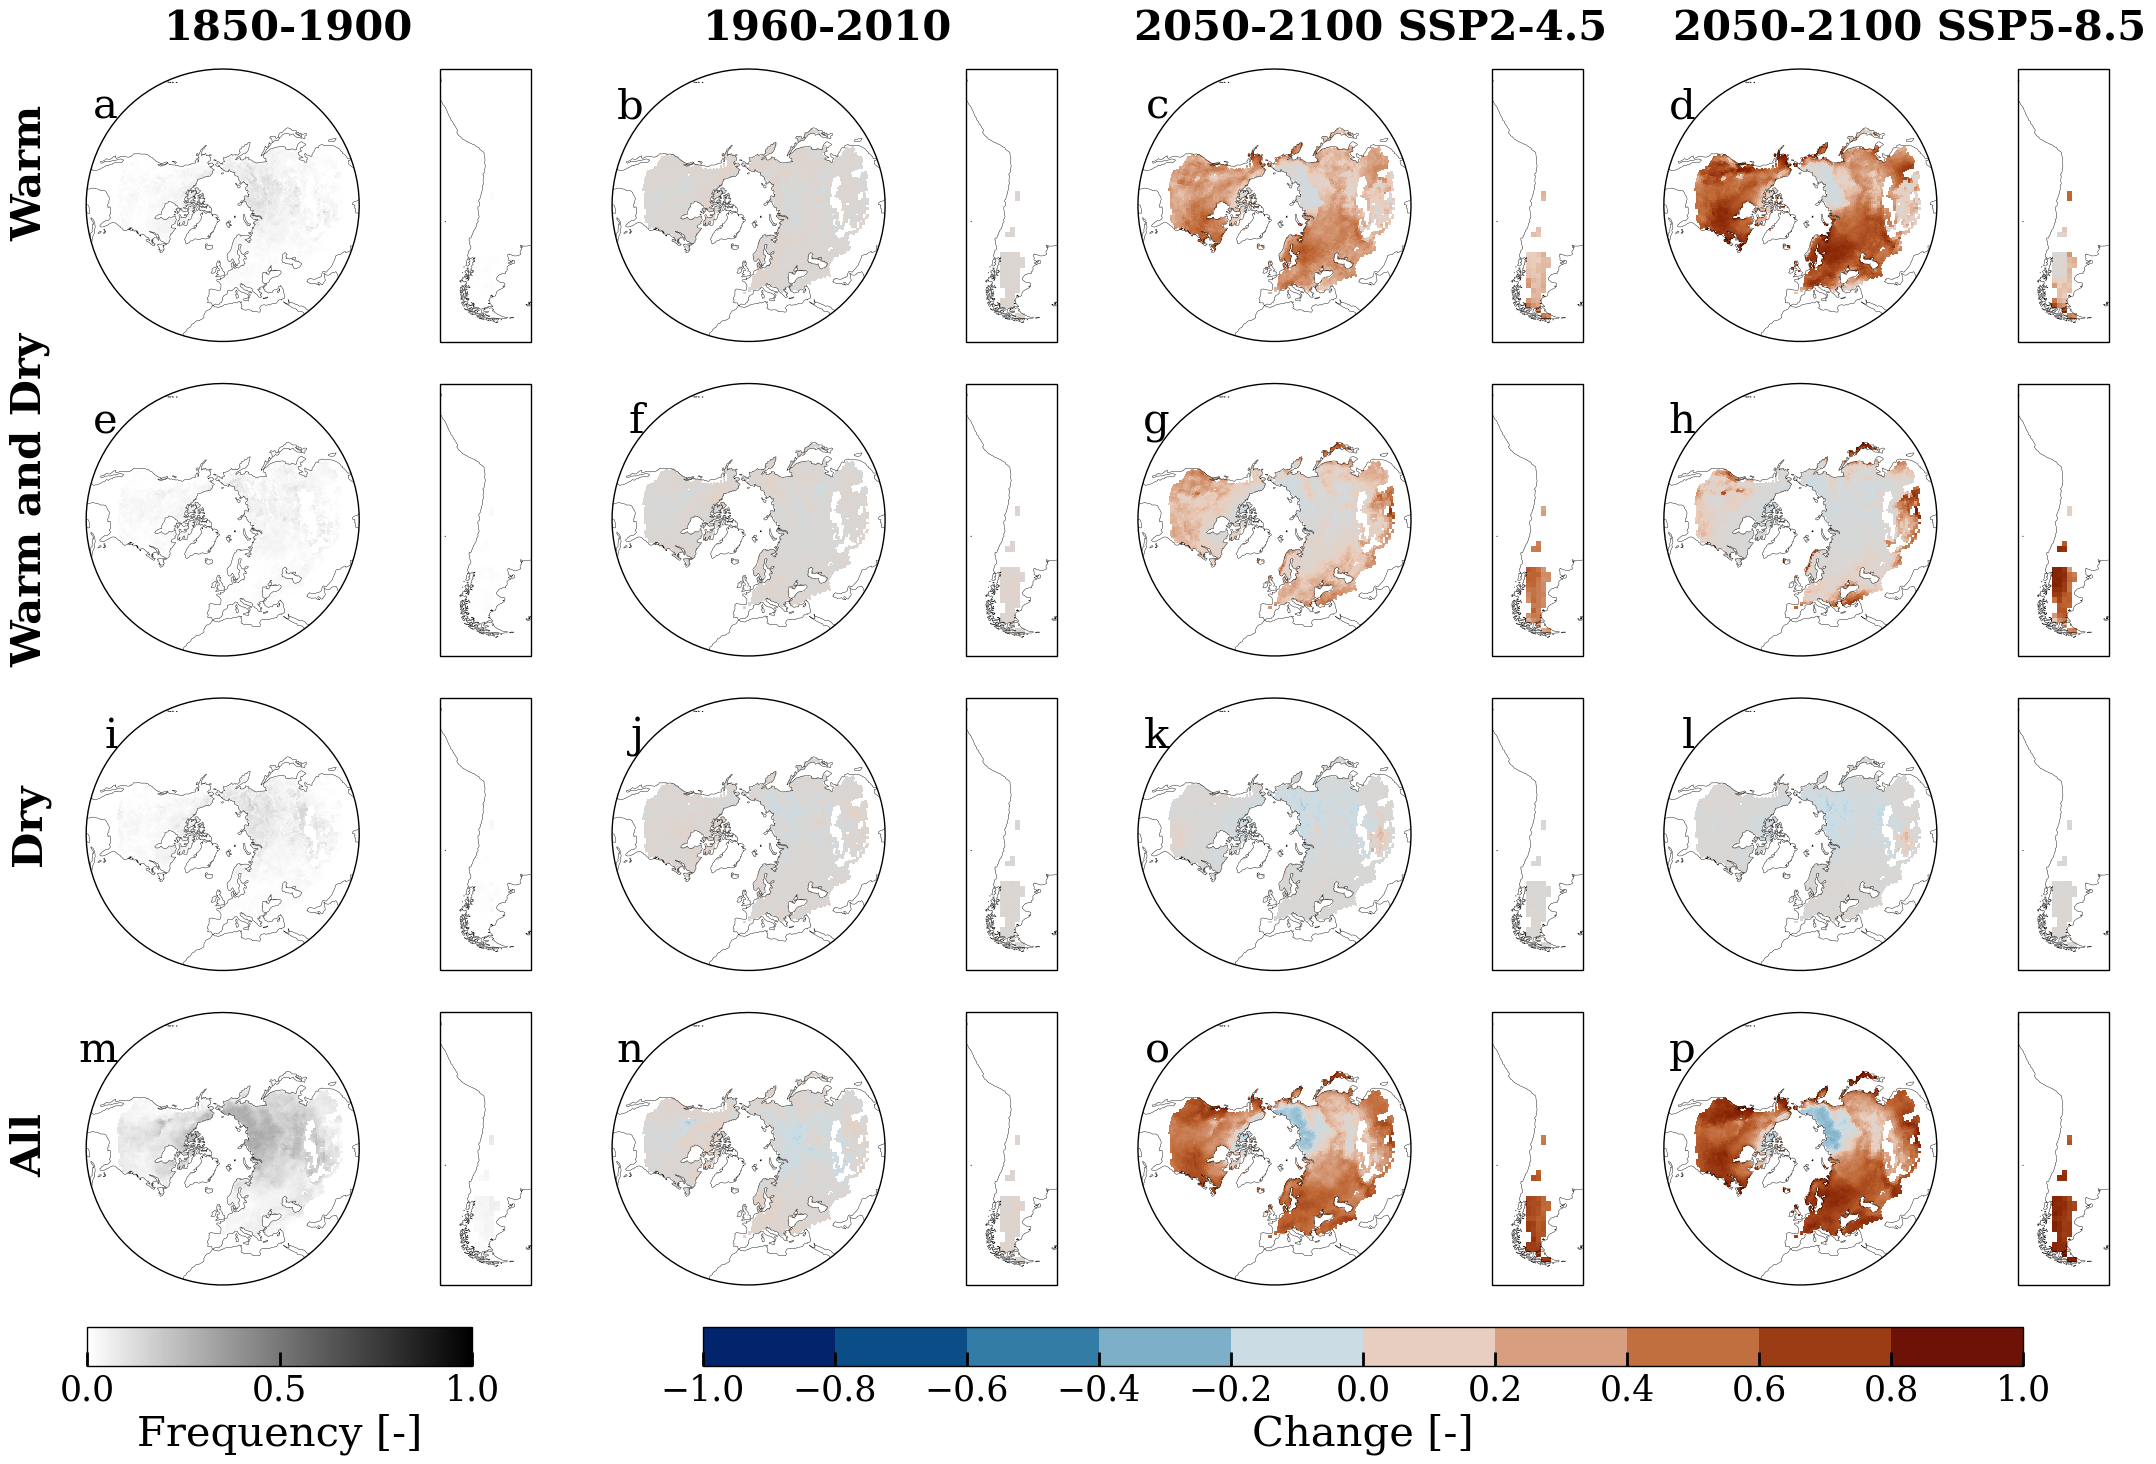

In [17]:
proj_circ = ccrs.NorthPolarStereo()
proj_flat = ccrs.PlateCarree()
SAVE = True
from matplotlib import colors
savename = 'freq_diff'
fig = plt.figure(figsize = (22,13))
c = 1

y = tmp.lat
x = tmp.lon
X, Y = np.meshgrid(x,y)

layout = [[['ssp245', 'warm', 1850],['ssp245', 'warm', 1960], ['ssp245', 'warm', 2050], ['ssp585', 'warm', 2050]],
          [['ssp245', 'warmdry', 1850],['ssp245', 'warmdry', 1960], ['ssp245', 'warmdry', 2050], ['ssp585', 'warmdry', 2050]],
          [['ssp245', 'dry', 1850],['ssp245', 'dry', 1960], ['ssp245', 'dry', 2050], ['ssp585', 'dry', 2050]],
          [['ssp245', 'all', 1850],['ssp245', 'all', 1960], ['ssp245', 'all', 2050], ['ssp585', 'all', 2050]]]

stats_fc = [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]]
savedata = [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]] 
          
for i in range(4):
    for j in range(4):
        exp = layout[i][j][0]
        drt = layout[i][j][1]
        yrs = layout[i][j][2]
        data = sddata[drt][exp]       
        ds_mean = xr.concat(data.values(), dim = 'model_id').mean(dim = 'model_id')
        data2plot = np.nanmean(ds_mean[0:50],axis = 0)
        data2save = data2plot
        cmap = cm.grayC
        vmin = 0 
        vmax = 1
        if j > 0:
            data2save = np.nanmean(ds_mean[yrs-1850:yrs-1800],axis = 0)
            data2plot = data2save - data2plot 
            cmap = cm.vik
            vmin = -1
            vmax = 1
        ax = fig.add_subplot(4,8,c ,projection=proj_circ)
        data2plot[~landicemask] = np.nan
        data2plot[~snowmask] = np.nan
        savedata[i][j] = data2save
        

        if j == 0:
            num_steps = 6
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb1 = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds1 = np.linspace(vmin, vmax, num_steps+1)
            norm1 = colors.BoundaryNorm(bounds1, new_cmap.N)
        else:
            num_steps = 10
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds0 = np.linspace(vmin, vmax, num_steps+1)
            norm0 = colors.BoundaryNorm(bounds0, new_cmap.N)

        polarCentral_set_latlim([20,90],ax)
        ax.text(230,20,chr(int(c/2) + 97),fontsize=30, transform = proj_flat,in_layout = False,ha='right')
        ax.coastlines(lw=0.3)
        c+=1
        ax = fig.add_subplot(4,8,c,projection=proj_flat)
        ax.pcolormesh(X,Y,data2plot ,cmap = new_cmap,transform = proj_flat, vmin = vmin, vmax = vmax)
        ax.coastlines(lw=0.3)
        ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())
        c+=1
        
        stats_fc[i][j] = np.nanmean(data2plot)

fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03])
cax1 = plt.axes([0.02, -0.03, .175, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15, ticks = bounds0, boundaries = bounds0).set_label(label='Change [-]',size=30)
cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Frequency [-]',size=30)

## text
x_base = -.2
y_base = 0
plt.text(x_base,y_base + 29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,y_base + 18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = 0.2
x_space = 1.4
y_level = 34
plt.text(x_base ,y_level ,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,y_level ,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space ,y_level ,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,y_level,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()    
if SAVE:
    fig.savefig(f'../figures/{savename}.jpg')


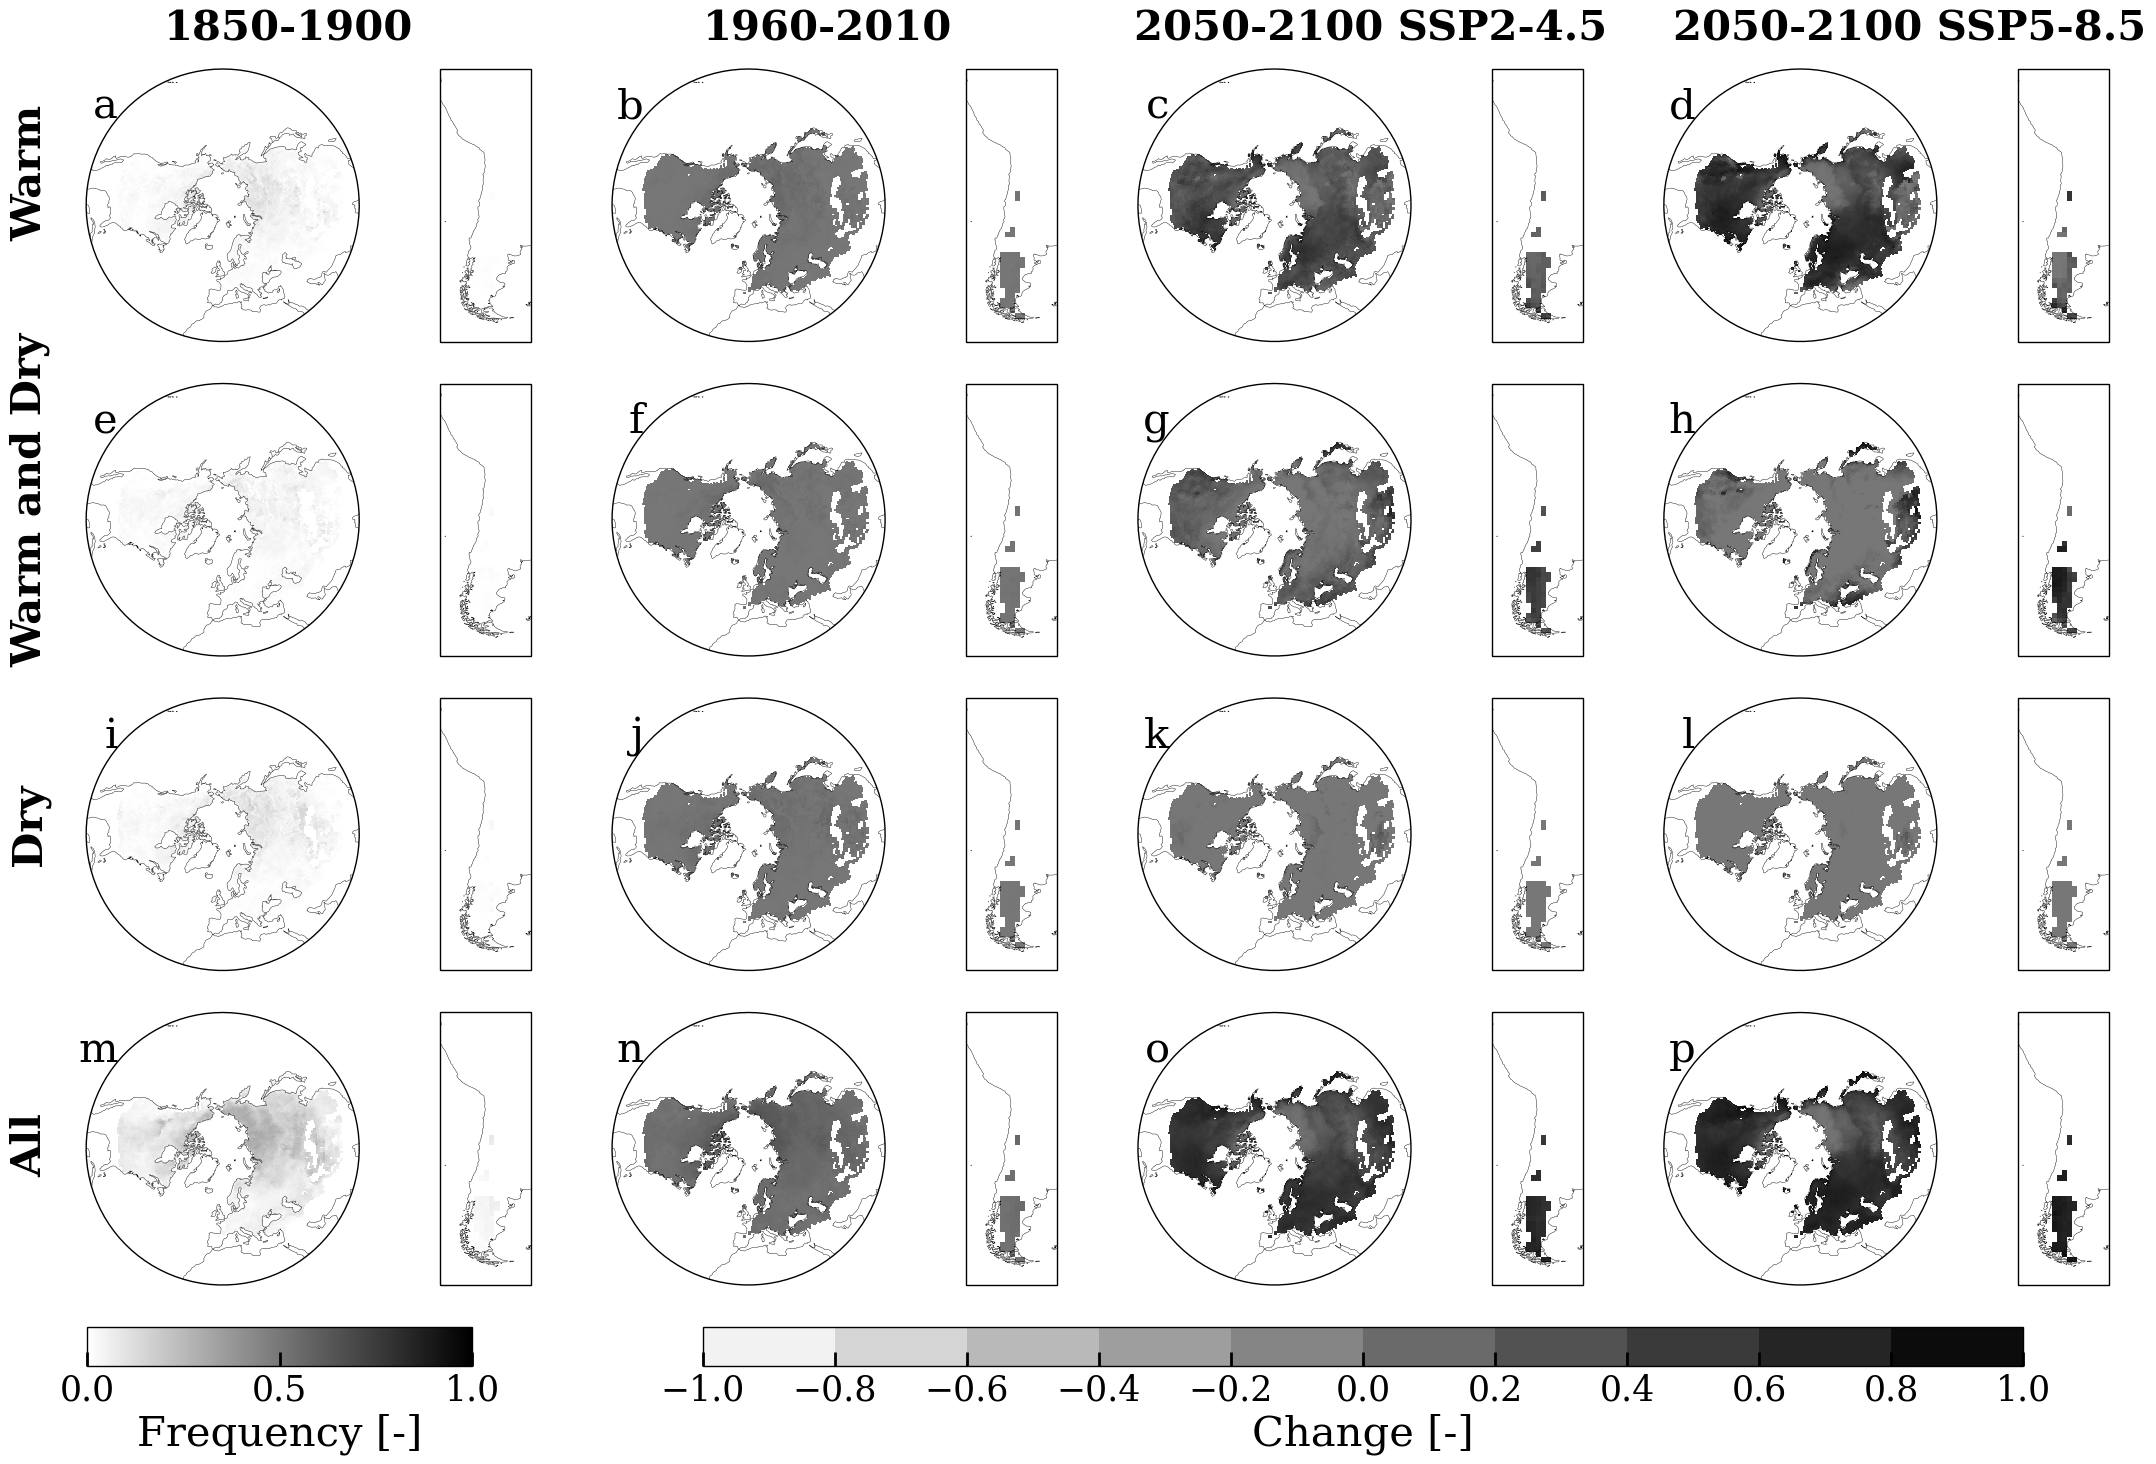

In [10]:
proj_circ = ccrs.NorthPolarStereo()
proj_flat = ccrs.PlateCarree()
SAVE = True
from matplotlib import colors
savename = 'freq'
fig = plt.figure(figsize = (22,13))
c = 1

y = tmp.lat
x = tmp.lon
X, Y = np.meshgrid(x,y)

layout = [[['ssp245', 'warm', 1850],['ssp245', 'warm', 1960], ['ssp245', 'warm', 2050], ['ssp585', 'warm', 2050]],
          [['ssp245', 'warmdry', 1850],['ssp245', 'warmdry', 1960], ['ssp245', 'warmdry', 2050], ['ssp585', 'warmdry', 2050]],
          [['ssp245', 'dry', 1850],['ssp245', 'dry', 1960], ['ssp245', 'dry', 2050], ['ssp585', 'dry', 2050]],
          [['ssp245', 'all', 1850],['ssp245', 'all', 1960], ['ssp245', 'all', 2050], ['ssp585', 'all', 2050]]]

stats = [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]]
savedata = [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]] 
          
for i in range(4):
    for j in range(4):
        exp = layout[i][j][0]
        drt = layout[i][j][1]
        yrs = layout[i][j][2]
        data = sddata[drt][exp]       
        ds_mean = xr.concat(data.values(), dim = 'model_id').mean(dim = 'model_id')
        data2plot = np.nanmean(ds_mean[0:50],axis = 0)
        data2save = data2plot
        cmap = cm.grayC
        vmin = 0 
        vmax = 1
        if j > 0:
            data2save = np.nanmean(ds_mean[yrs-1850:yrs-1800],axis = 0)
            data2plot = data2save #  - data2plot no difference just plot it
            cmap = cm.grayC
            vmin = -1
            vmax = 1
        ax = fig.add_subplot(4,8,c ,projection=proj_circ)
        data2plot[~landicemask] = np.nan
        data2plot[~snowmask] = np.nan
        savedata[i][j] = data2save
        

        if j == 0:
            num_steps = 6
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb1 = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds1 = np.linspace(vmin, vmax, num_steps+1)
            norm1 = colors.BoundaryNorm(bounds1, new_cmap.N)
        else:
            num_steps = 10
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds0 = np.linspace(vmin, vmax, num_steps+1)
            norm0 = colors.BoundaryNorm(bounds0, new_cmap.N)

        polarCentral_set_latlim([20,90],ax)
        ax.text(230,20,chr(int(c/2) + 97),fontsize=30, transform = proj_flat,in_layout = False,ha='right')
        ax.coastlines(lw=0.3)
        c+=1
        ax = fig.add_subplot(4,8,c,projection=proj_flat)
        ax.pcolormesh(X,Y,data2plot ,cmap = new_cmap,transform = proj_flat, vmin = vmin, vmax = vmax)
        ax.coastlines(lw=0.3)
        ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())
        c+=1
        
        stats[i][j] = np.nanmean(data2plot)

fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03])
cax1 = plt.axes([0.02, -0.03, .175, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15, ticks = bounds0, boundaries = bounds0).set_label(label='Change [-]',size=30)
cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Frequency [-]',size=30)

## text
x_base = -.2
y_base = 0
plt.text(x_base,y_base + 29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,y_base + 18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = 0.2
x_space = 1.4
y_level = 34
plt.text(x_base ,y_level ,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,y_level ,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space ,y_level ,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,y_level,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()    
if SAVE:
    fig.savefig(f'../figures/{savename}_val.jpg')


In [11]:
## print the relevant statistics
# 1 frequency changes in all droughts:
print(f'''Compared to a historical baseline (1850--1900), we found a total snow drought frequency increase 
 of {round(stats[3][2] / stats[3][0] * 100)} ({round(stats[3][3] / stats[3][0] * 100)}) percent under SSP2-4.5 (SSP5-8.5).
''')
# what percentage comes from warm droughts? i.e. i = 0
print(stats[0][2] + stats[1][2] + stats[2][2] - stats[3][2], ' percent from neither warm nor dry')
print((stats[0][2] + stats[1][2]) / stats[3][2] * 100, ' percent NOT dry')

Compared to a historical baseline (1850--1900), we found a total snow drought frequency increase 
 of 328 (389) percent under SSP2-4.5 (SSP5-8.5).

-0.01082749487354756  percent from neither warm nor dry
95.22984459919304  percent NOT dry


In [ ]:
"""The majority ($>$99\%) of this modeled increase is due to an increase in warm drought or warm and dry drought.
Dry drought alone is predicted to decrease by an average of 3.2 (3.5)\%.  
Warm drought alone, however, increases by 
"""

In [15]:
stats[0][2] / (stats[0][2] + stats[1][2])

0.7127983183898972

In [16]:
stats[0][3] / (stats[0][3] + stats[1][3])

0.8795162533274381

In [48]:
# frequency changes for all droughts
print('all')
print('SSP2-4.5')
print(np.nanmean(savedata[3][2] - savedata[3][0]))
print(np.nanstd(savedata[3][2] - savedata[3][0]))
print('SSP5-8.5')
print(np.nanmean(savedata[3][3] - savedata[3][0]))
print(np.nanstd(savedata[3][3] - savedata[3][0]))


# dry drought:
print('dry drought')
print('SSP2-4.5')
print(stats[2][2] *100)
print(stats[2][3] * 100)

# frequency changes for warm droughts
print('warm')
print('SSP2-4.5')
print(np.nanmean(savedata[0][2] - savedata[0][0]))
print(np.nanstd(savedata[0][2] - savedata[0][0]))
print('SSP5-8.5')
print(np.nanmean(savedata[0][3] - savedata[0][0]))
print(np.nanstd(savedata[0][3] - savedata[0][0]))

print('warm dry')
print('SSP2-4.5')
# frequency changes for warm and dry droughts
print(np.nanmean(savedata[1][2] - savedata[1][0]))
print(np.nanstd(savedata[1][2] - savedata[1][0]))
print('SSP5-8.5')
print(np.nanmean(savedata[1][3] - savedata[1][0]))
print(np.nanstd(savedata[1][3] - savedata[1][0]))


## warm alone droughts were
print('warm + warm and dry')
print(stats[0][2] + stats[1][2])
print('warm + warm and dry + dry')
print(stats[0][2] + stats[1][2] + stats[2][2])
print('pct warm alone')
print(stats[0][2]/ stats[3][2])
print(np.nanstd((savedata[0][2] - savedata[0][0])))
print('pct warm+dry alone')
print(stats[1][2] / stats[3][2])
print(stats[3][2])

print('SSP5-8.5')
print('pct warm alone')
print(stats[0][3] / stats[3][3])
print(np.nanstd((savedata[0][3] - savedata[0][0])))
print('pct warm+dry alone')
print(stats[1][3] / stats[3][3])

#print(np.nanmean(savedata[1][2] - savedata[3][0]))

all
SSP2-4.5
0.30469753930280247
0.2565456410677889
SSP5-8.5
0.3851973684210527
0.2999013734950936
dry drought
SSP2-4.5
1.0072624743677376
0.20377648667122356
warm
SSP2-4.5
0.2598722658920028
0.1660516290228861
SSP5-8.5
0.415410970608339
0.2448348731464276
warm dry
SSP2-4.5
0.09303272385509227
0.12119152618493222
SSP5-8.5
0.03524863294600136
0.14031797526698145
warm + warm and dry
0.41724325017088176
warm + warm and dry + dry
0.42731587491455914
pct warm alone
0.6787967309083605
0.1660516290228861
pct warm+dry alone
0.2735017150835701
0.4381433697881067
SSP5-8.5
pct warm alone
0.8733344865078579
0.2448348731464276
pct warm+dry alone
0.11963691476392872


In [ ]:
proj_circ = ccrs.NorthPolarStereo()
proj_flat = ccrs.PlateCarree()
SAVE = False
savename = 'sev_diff'
fig = plt.figure(figsize = (22,13))
c = 1

y = tmp.lat
x = tmp.lon
X, Y = np.meshgrid(x,y)

layout = [[['ssp245', 'warm', 1850],['ssp245', 'warm', 1960], ['ssp245', 'warm', 2050], ['ssp585', 'warm', 2050]],
          [['ssp245', 'warmdry', 1850],['ssp245', 'warmdry', 1960], ['ssp245', 'warmdry', 2050], ['ssp585', 'warmdry', 2050]],
          [['ssp245', 'dry', 1850],['ssp245', 'dry', 1960], ['ssp245', 'dry', 2050], ['ssp585', 'dry', 2050]],
          [['ssp245', 'all', 1850],['ssp245', 'all', 1960], ['ssp245', 'all', 2050], ['ssp585', 'all', 2050]]]
stats_sev = [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]]

savedata_sev =  [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]]
 
for i in range(4):
    for j in range(4):
        exp = layout[i][j][0]
        drt = layout[i][j][1]
        yrs = layout[i][j][2]
        
        #allswei = sddata['swei'][exp].copy()
        modeldata_base = []
        modeldata_plot = []
        for model in allnames2:
            ds = xr.open_dataset(f'{savepath}swei_max_{model}_{exp}.nc')
            #ds = swei_datasets_maxsnw[f'{model}_{exp}']
            #masks = categs[f'{model}_{exp}']
            masks = xr.open_dataset(f'{savepath}categs_{model}_{exp}.nc')
            mask = None
            if drt == 'all':
                mask = masks['swei_cond']
            elif drt == 'warm':
                mask = masks['swei_cond'] & masks['tas_cond'] & ~masks['pr_cond']
            elif drt == 'warmdry':
                mask = masks['swei_cond'] & masks['tas_cond'] & masks['pr_cond']
            elif drt == 'dry':
                mask = masks['swei_cond'] & ~masks['tas_cond'] & ~masks['pr_cond']

            tmp_base = ds['swei'].where(mask.values)[0:50].mean(dim = 'year')
            tmp_base = tmp_base.where(landicesnowmask)
            modeldata_base.append(tmp_base)
    
            tmp = ds['swei'].where(mask.values)[yrs-1850:yrs-1800].mean(dim = 'year')
            tmp = tmp.where(landicesnowmask)
            modeldata_plot.append(tmp)
  
        ds_concat = xr.concat(modeldata_plot, dim = 'model_id')
        ds_mean = ds_concat.mean(dim = 'model_id')
        
        ds_concat_base = xr.concat(modeldata_base, dim = 'model_id')
        ds_mean_base = ds_concat_base.mean(dim = 'model_id')
        
        data2plot = ds_mean_base
        data2save = ds_mean_base
        cmap = cm.grayC_r
        vmin = -np.e 
        vmax = -0.8
        
        if j > 0:
            data2save = ds_mean
            ## difference ## 
            data2plot = ds_mean - ds_mean_base
            cmap = cm.bam
            vmin = -0.7
            vmax = 0.7
        savedata_sev[i][j] = data2save
        ax = fig.add_subplot(4,8,c ,projection=proj_circ)
        if j == 0:
            num_steps = 6
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb1 = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds1 = np.linspace(vmin, vmax, num_steps+1)
            norm1 = colors.BoundaryNorm(bounds1, new_cmap.N)
        else:
            num_steps = 10
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds0 = np.linspace(vmin, vmax, num_steps+1)
            norm0 = colors.BoundaryNorm(bounds0, new_cmap.N)

        polarCentral_set_latlim([20,90],ax)
        ax.text(230,20,chr(int(c/2) + 97),fontsize=30, transform = proj_flat,in_layout = False,ha='right')
        ax.coastlines(lw=0.3)
        c+=1
        ax = fig.add_subplot(4,8,c,projection=proj_flat)
        ax.pcolormesh(X,Y,data2plot ,cmap = cmap,transform = proj_flat, vmin = vmin, vmax = vmax)
        ax.coastlines(lw=0.3)
        ax.set_extent([-80,-60,-60,0],crs = proj_flat)
        c+=1
        stats_sev[i][j] = np.nanmean(data2plot)


fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03])
cax1 = plt.axes([0.02, -0.03, .175, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15, ticks = bounds0, boundaries = bounds0).set_label(label='Change [-]',size=30)
cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Severity [-]',size=30)


## text
x_base = -3.1
y_base = 0
plt.text(x_base,y_base + 29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,y_base + 18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = -2.0
x_space = 3.6
y_level = 34
plt.text(x_base ,y_level ,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,y_level ,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space ,y_level ,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,y_level,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()    
if SAVE:
    fig.savefig(f'../figures/{savename}.jpg')


In [ ]:
proj_circ = ccrs.NorthPolarStereo()
proj_flat = ccrs.PlateCarree()
SAVE = False
savename = 'sev_diff'
fig = plt.figure(figsize = (22,13))
c = 1

y = tmp.lat
x = tmp.lon
X, Y = np.meshgrid(x,y)

layout = [[['ssp245', 'warm', 1850],['ssp245', 'warm', 1960], ['ssp245', 'warm', 2050], ['ssp585', 'warm', 2050]],
          [['ssp245', 'warmdry', 1850],['ssp245', 'warmdry', 1960], ['ssp245', 'warmdry', 2050], ['ssp585', 'warmdry', 2050]],
          [['ssp245', 'dry', 1850],['ssp245', 'dry', 1960], ['ssp245', 'dry', 2050], ['ssp585', 'dry', 2050]],
          [['ssp245', 'all', 1850],['ssp245', 'all', 1960], ['ssp245', 'all', 2050], ['ssp585', 'all', 2050]]]
stats_sev = [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]]

savedata_sev =  [[[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]]
 
for i in range(4):
    for j in range(4):
        exp = layout[i][j][0]
        drt = layout[i][j][1]
        yrs = layout[i][j][2]
        
        #allswei = sddata['swei'][exp].copy()
        modeldata_base = []
        modeldata_plot = []
        for model in allnames2:
            ds = xr.open_dataset(f'{savepath}swei_max_{model}_{exp}.nc')
            #ds = swei_datasets_maxsnw[f'{model}_{exp}']
            #masks = categs[f'{model}_{exp}']
            masks = xr.open_dataset(f'{savepath}categs_{model}_{exp}.nc')
            mask = None
            if drt == 'all':
                mask = masks['swei_cond']
            elif drt == 'warm':
                mask = masks['swei_cond'] & masks['tas_cond'] & ~masks['pr_cond']
            elif drt == 'warmdry':
                mask = masks['swei_cond'] & masks['tas_cond'] & masks['pr_cond']
            elif drt == 'dry':
                mask = masks['swei_cond'] & ~masks['tas_cond'] & ~masks['pr_cond']

            tmp_base = ds['swei'].where(mask.values)[0:50].mean(dim = 'year')
            tmp_base = tmp_base.where(landicesnowmask)
            modeldata_base.append(tmp_base)
    
            tmp = ds['swei'].where(mask.values)[yrs-1850:yrs-1800].mean(dim = 'year')
            tmp = tmp.where(landicesnowmask)
            modeldata_plot.append(tmp)
  
        ds_concat = xr.concat(modeldata_plot, dim = 'model_id')
        ds_mean = ds_concat.mean(dim = 'model_id')
        
        ds_concat_base = xr.concat(modeldata_base, dim = 'model_id')
        ds_mean_base = ds_concat_base.mean(dim = 'model_id')
        
        data2plot = ds_mean_base
        data2save = ds_mean_base
        cmap = cm.grayC_r
        vmin = -np.e 
        vmax = -0.8
        
        if j > 0:
            data2save = ds_mean
            ## value ## 
            data2plot = ds_mean
            cmap = cm.bam
            vmin = -0.7
            vmax = 0.7
        savedata_sev[i][j] = data2save
        ax = fig.add_subplot(4,8,c ,projection=proj_circ)
        if j == 0:
            num_steps = 6
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb1 = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds1 = np.linspace(vmin, vmax, num_steps+1)
            norm1 = colors.BoundaryNorm(bounds1, new_cmap.N)
        else:
            num_steps = 10
            new_cmap = colors.LinearSegmentedColormap.from_list(
            'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
            cb = ax.pcolormesh(X,Y,data2plot, transform = proj_flat, cmap = new_cmap, vmin = vmin, vmax = vmax)
            bounds0 = np.linspace(vmin, vmax, num_steps+1)
            norm0 = colors.BoundaryNorm(bounds0, new_cmap.N)

        polarCentral_set_latlim([20,90],ax)
        ax.text(230,20,chr(int(c/2) + 97),fontsize=30, transform = proj_flat,in_layout = False,ha='right')
        ax.coastlines(lw=0.3)
        c+=1
        ax = fig.add_subplot(4,8,c,projection=proj_flat)
        ax.pcolormesh(X,Y,data2plot ,cmap = cmap,transform = proj_flat, vmin = vmin, vmax = vmax)
        ax.coastlines(lw=0.3)
        ax.set_extent([-80,-60,-60,0],crs = proj_flat)
        c+=1
        stats_sev[i][j] = np.nanmean(data2plot)


fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03])
cax1 = plt.axes([0.02, -0.03, .175, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15, ticks = bounds0, boundaries = bounds0).set_label(label='Change [-]',size=30)
cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Severity [-]',size=30)


## text
x_base = -3.1
y_base = 0
plt.text(x_base,y_base + 29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,y_base + 18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,y_base + 5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = -2.0
x_space = 3.6
y_level = 34
plt.text(x_base ,y_level ,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,y_level ,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space ,y_level ,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,y_level,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()    
if SAVE:
    fig.savefig(f'../figures/{savename}.jpg')


In [ ]:
stats_sev

In [49]:
# severity changes
print(np.nanmean(savedata_sev[3][2] - savedata_sev[3][0]))
print(np.nanstd(savedata_sev[3][2] - savedata_sev[3][0]))
print(np.nanmean(savedata_sev[3][3] - savedata_sev[3][0]))
print(np.nanstd(savedata_sev[3][3] - savedata_sev[3][0]))
print(stats_sev)
table1 = np.zeros((4,4))
table2 = np.zeros((4,4))
print('frequency')
for i in range(4):
    for j in range(4):
        table1[i,j] = (np.nanmean(savedata[i][j]))
print('severity')
for i in range(4):
    for j in range(4):
        table2[i,j] = np.nanmean(savedata_sev[i][j])
print(table1)
print(table2)

NameError: name 'savedata_sev' is not defined

## everything after this is not in the paper

In [50]:
## load intermodel mean swe, swei, pr, tas
swe_hist = xr.open_dataset(savepath + 'snw_model_mean_historical.nc')
swe_245 = xr.open_dataset(savepath + 'snw_model_mean_ssp245.nc')
swe_585 = xr.open_dataset(savepath + 'snw_model_mean_ssp585.nc')
pr_hist = xr.open_dataset(savepath + 'pr_model_mean_historical.nc')
pr_245 = xr.open_dataset(savepath + 'pr_model_mean_ssp245.nc')
pr_585 = xr.open_dataset(savepath + 'pr_model_mean_ssp585.nc')
tas_hist = xr.open_dataset(savepath + 'tas_model_mean_historical.nc')
tas_245 = xr.open_dataset(savepath + 'tas_model_mean_ssp245.nc')
tas_585 = xr.open_dataset(savepath + 'tas_model_mean_ssp585.nc')



In [51]:
## make baselines 
pr_baseline = pr_hist.sel(time = pr_hist.time.dt.year.isin(range(1850,1950))).squeeze()
pr_monthly_mean = pr_hist.groupby(pr_hist['time.month']).mean()
pr_monthly_mean_baseline = pr_baseline.groupby(pr_baseline['time.month']).mean()
tas_baseline = tas_hist.sel(time = tas_hist.time.dt.year.isin(range(1850,1950))).squeeze()
tas_monthly_mean = tas_hist.groupby(tas_hist['time.month']).mean()
tas_monthly_mean_baseline = tas_baseline.groupby(tas_baseline['time.month']).mean()

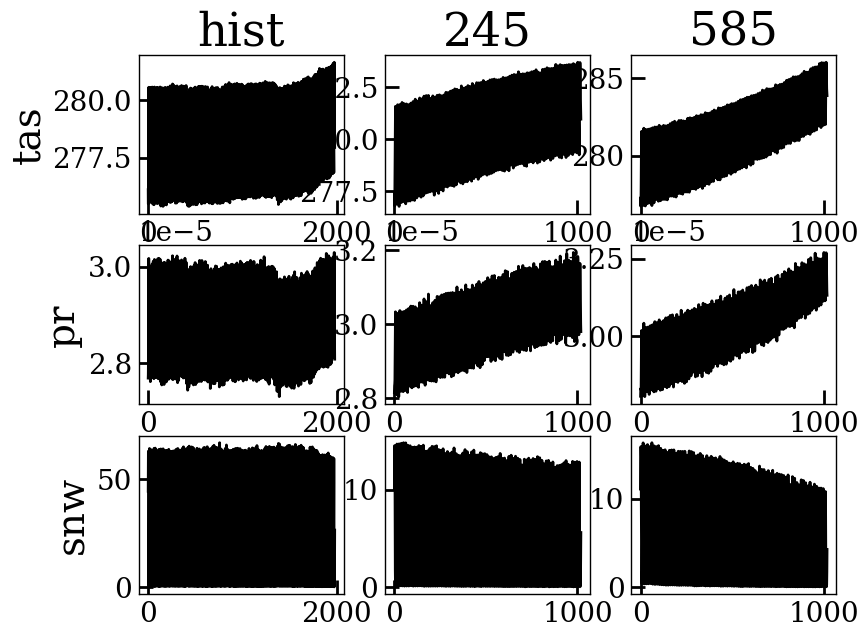

In [52]:
fig,axs=plt.subplots(3,3)
axs[0,0].plot(np.nanmean((tas_hist['tas']), axis = (1,2)))
axs[0,0].set_ylabel('tas')
axs[0,0].set_title('hist')
axs[1,0].plot(np.nanmean((pr_hist['pr']), axis = (1,2)))
axs[1,0].set_ylabel('pr')
axs[2,0].plot(np.nanmean((swe_hist['snw']),axis = (1,2)))
axs[2,0].set_ylabel('snw')
axs[0,1].plot(np.nanmean((tas_245['tas']), axis = (1,2)))
axs[0,1].set_title('245')
axs[1,1].plot(np.nanmean((pr_245['pr']), axis = (1,2)))
axs[2,1].plot(np.nanmean((swe_245['snw']), axis = (1,2)))
axs[0,2].plot(np.nanmean((tas_585['tas']), axis = (1,2)))
axs[0,2].set_title('585')
axs[1,2].plot(np.nanmean((pr_585['pr']), axis = (1,2)))
axs[2,2].plot(np.nanmean((swe_585['snw']), axis = (1,2)))
plt.show()

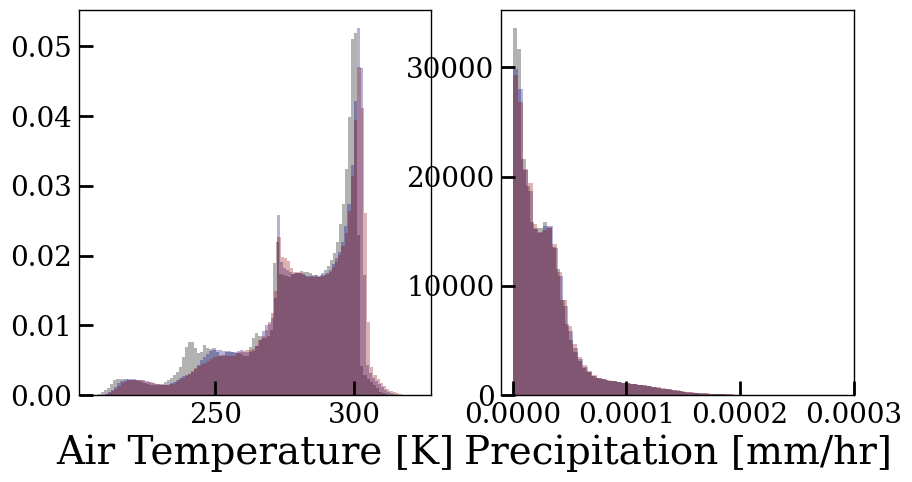

In [53]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_xlabel('Air Temperature [K]')
axs[0].hist((tas_hist['tas']).data.flatten(), bins = 100, label = 'hist', density = True, alpha = 0.3)
axs[0].hist((tas_245['tas']).data.flatten(), bins = 100, label = 'SSP2-4.5', density = True, alpha = 0.3, color = 'darkblue')
axs[0].hist((tas_585['tas']).data.flatten(), bins = 100, label = 'SSP5-8.5', density = True, alpha = 0.3, color = 'darkred')
axs[0].legend
axs[1].set_xlabel('Precipitation [mm/hr]')
axs[1].hist((pr_hist['pr']).data.flatten(),bins =100,  density = True, alpha = 0.3)
axs[1].hist((pr_245['pr']).data.flatten(), bins = 100, density = True, alpha = 0.3, color = 'darkblue')
axs[1].hist((pr_585['pr']).data.flatten(), bins = 100, density = True, alpha = 0.3, color = 'darkred')
axs[1].set_xlim((-0.00001,0.0003))
plt.show()

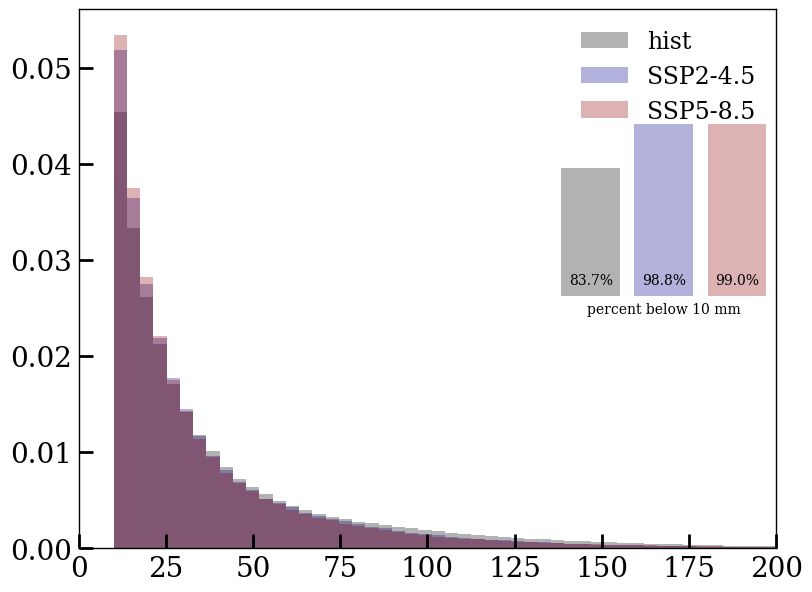

In [54]:
fig,ax=plt.subplots()
sh = (swe_hist['snw'][:,35:-35,:]).data.flatten()
s2 = (swe_245['snw'][:,35:-35,:]).data.flatten()
s5 =  (swe_585['snw'][:,35:-35,:]).data.flatten()
cutoff = 10
ax.hist(sh[(sh > cutoff) & (sh < 200)], bins = 50, density = True, label = 'hist', alpha = 0.3, color = 'black')
ax.hist(s2[(s2 > cutoff) & (s2 < 200)], bins = 50, density = True, label = 'SSP2-4.5', alpha = 0.3, color = 'darkblue')
ax.hist(s5[(s5 > cutoff) & (s5 < 200)], bins = 50, density = True, label = 'SSP5-8.5', alpha = 0.3, color = 'darkred')
ax.set_xlim((0,200))
ax.legend(loc = 'upper right')
nh = len(sh[sh<=cutoff])/len(sh[~np.isnan(sh)])
n2 = len(s2[s2<=cutoff])/len(s2[~np.isnan(s2)]) 
n5 = len(s5[s5<=cutoff])/len(s5[~np.isnan(s5)]) 
ax_inset = plt.axes([0.65,0.47,0.25,0.25], frameon = False)
ax_inset.bar([0],[nh], color = 'k', alpha = 0.3)
ax_inset.bar([1],[n2], color = 'darkblue', alpha = 0.3)
ax_inset.bar([2],[n5], color = 'darkred', alpha = 0.3)
ax_inset.set_xlabel(f'percent below {cutoff} mm', fontsize = 10)
for i, value in enumerate([nh, n2, n5]):
    ax_inset.text(i, 0.441, f"{100 * value:.1f}%", ha='center', fontsize = 10)
ax_inset.set_ylim((0.4,1))
ax_inset.set_xticks([])
ax_inset.set_yticks([])
plt.show()

In [72]:
gc.collect()
pr_long585 = xr.concat([pr_hist,pr_585],dim = 'time')
tas_long585 = xr.concat([tas_hist,tas_585],dim = 'time')
pr_long245  = xr.concat([pr_hist,pr_245],dim = 'time')
tas_long245 = xr.concat([tas_hist,tas_245],dim = 'time')

tmp = pr_long585['pr'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(pr_monthly_mean_baseline['pr'].data[np.newaxis,:,:,:],250,axis=0)
pr_585_anom = tmp - baselinetmp
tmp = tas_long585['tas'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(tas_monthly_mean_baseline['tas'].data[np.newaxis,:,:,:],250,axis=0)
tas_585_anom = tmp - baselinetmp
tas_585_anom[:,:,:,160] = np.nan

tmp = pr_long245['pr'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(pr_monthly_mean_baseline['pr'].data[np.newaxis,:,:,:],250,axis=0)
pr_245_anom = tmp - baselinetmp
tmp = tas_long245['tas'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(tas_monthly_mean_baseline['tas'].data[np.newaxis,:,:,:],250,axis=0)
tas_245_anom = tmp - baselinetmp
tas_245_anom[:,:,:,160] = np.nan


del tmp
del baselinetmp
gc.collect()

years = [0, 110, 200]
print([1850 + y for y in years])

pr_anom585 = pr_585_anom.transpose((2,3,0,1))
tas_anom585 = tas_585_anom.transpose((2,3,0,1))
pr_anom245 = pr_245_anom.transpose((2,3,0,1))
tas_anom245 = tas_245_anom.transpose((2,3,0,1))

tas_cutoff =  0 # np.nanpercentile(tas_anom245,67)
#np.nanpercentile(tas_monthly_mean_baseline['tas_model_mean'].data,33)
pr_cutoff =  0 #np.nanpercentile(pr_anom245,33)
#np.nanpercentile(pr_monthly_mean_baseline['pr_model_mean'].data,67)
'''
dd245 = (swei245 < -0.8) & (tas_anom245 <= tas_cutoff) & (pr_anom245 < pr_cutoff) # dry drought
wd245 = (swei245 < -0.8) & (tas_anom245 > tas_cutoff) & (pr_anom245 >= pr_cutoff) # warm drought
dwd245 = (swei245 < -0.8) & (tas_anom245 > tas_cutoff) & (pr_anom245 < pr_cutoff) # dry warm drought
nd245 = (swei245 < -0.8) & (tas_anom245 <= tas_cutoff) & (pr_anom245 >= pr_cutoff) # neither dry nor warm
d245 = (swei245 < -0.8)

dd585 = (swei585 < -0.8) & (tas_anom585 <= tas_cutoff) & (pr_anom585 < pr_cutoff)
wd585 = (swei585 < -0.8) & (tas_anom585 > tas_cutoff) & (pr_anom585 >= pr_cutoff)
dwd585 = (swei585 < -0.8) & (tas_anom585 > tas_cutoff) & (pr_anom585 < pr_cutoff)
nd585 = (swei585 < -0.8) & (tas_anom585 <= tas_cutoff) & (pr_anom585 >= pr_cutoff)
d585 = (swei585 < -0.8)

y = pr_hist['lat']
x = pr_hist['lon']
snowmask =np.nansum(swe_hist['snw'],axis = (0) ) < 50

plotdata = []
for starty in years:
    for dataset in [wd245,dwd245,dd245,d245,wd585,dwd585,dd585,d585]:
        tmp = dataset[:,:,starty:starty+50,:]
        tmp = np.nansum(tmp,axis = (2,3)).astype(float)
        tmp[(y>60)| (y < -60)] = np.nan
        tmp[snowmask] = np.nan
        plotdata.append(tmp)
'''

[1850, 1960, 2050]


"\ndd245 = (swei245 < -0.8) & (tas_anom245 <= tas_cutoff) & (pr_anom245 < pr_cutoff) # dry drought\nwd245 = (swei245 < -0.8) & (tas_anom245 > tas_cutoff) & (pr_anom245 >= pr_cutoff) # warm drought\ndwd245 = (swei245 < -0.8) & (tas_anom245 > tas_cutoff) & (pr_anom245 < pr_cutoff) # dry warm drought\nnd245 = (swei245 < -0.8) & (tas_anom245 <= tas_cutoff) & (pr_anom245 >= pr_cutoff) # neither dry nor warm\nd245 = (swei245 < -0.8)\n\ndd585 = (swei585 < -0.8) & (tas_anom585 <= tas_cutoff) & (pr_anom585 < pr_cutoff)\nwd585 = (swei585 < -0.8) & (tas_anom585 > tas_cutoff) & (pr_anom585 >= pr_cutoff)\ndwd585 = (swei585 < -0.8) & (tas_anom585 > tas_cutoff) & (pr_anom585 < pr_cutoff)\nnd585 = (swei585 < -0.8) & (tas_anom585 <= tas_cutoff) & (pr_anom585 >= pr_cutoff)\nd585 = (swei585 < -0.8)\n\ny = pr_hist['lat']\nx = pr_hist['lon']\nsnowmask =np.nansum(swe_hist['snw'],axis = (0) ) < 50\n\nplotdata = []\nfor starty in years:\n    for dataset in [wd245,dwd245,dd245,d245,wd585,dwd585,dd585,d585]:\n 

In [ ]:
print (1850, 1850 + 50)
print (1960, 1970 + 50)
print (2050, 2050 + 50)

In [ ]:
plt.pcolormesh(categs['ACCESS-CM2_ssp245']['swei_cond'][100,:,:])

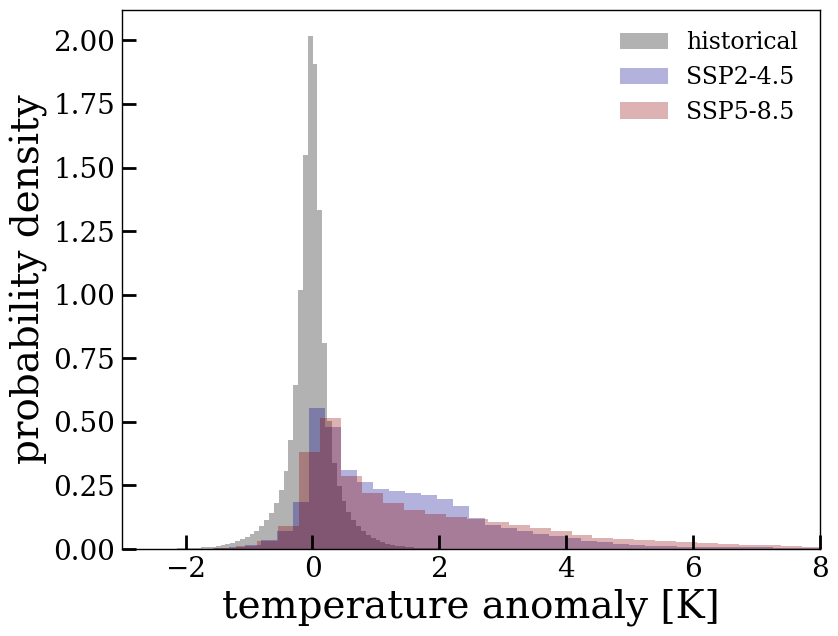

In [92]:
fig,ax= plt.subplots()
ax.hist(tas_anom245[:,35:-35,0:85,:].flatten(),bins = 100,alpha = 0.3, label = 'historical', density = True)
ax.hist(tas_anom245[:,35:-35,85:,:].flatten(),bins = 100,alpha = 0.3, label = 'SSP2-4.5', density = True, color = 'darkblue')
ax.hist(tas_anom585[:,35:-35,85:,:].flatten(),bins = 100,alpha = 0.3, label = 'SSP5-8.5', density = True, color = 'darkred')
# ax.vlines(tas_cutoff,0,1.4)
ax.set_ylabel('probability density')

ax.set_xlabel('temperature anomaly [K]')
ax.set_xlim((-3,8))
plt.legend()
plt.show()

In [83]:
seconds_per_year = 3.15576e+7
pr_anom245_per_year = pr_anom245  * seconds_per_year
pr_anom585_per_year = pr_anom585 * seconds_per_year

In [89]:
pr_anom245_per_year.shape

(160, 320, 250, 12)

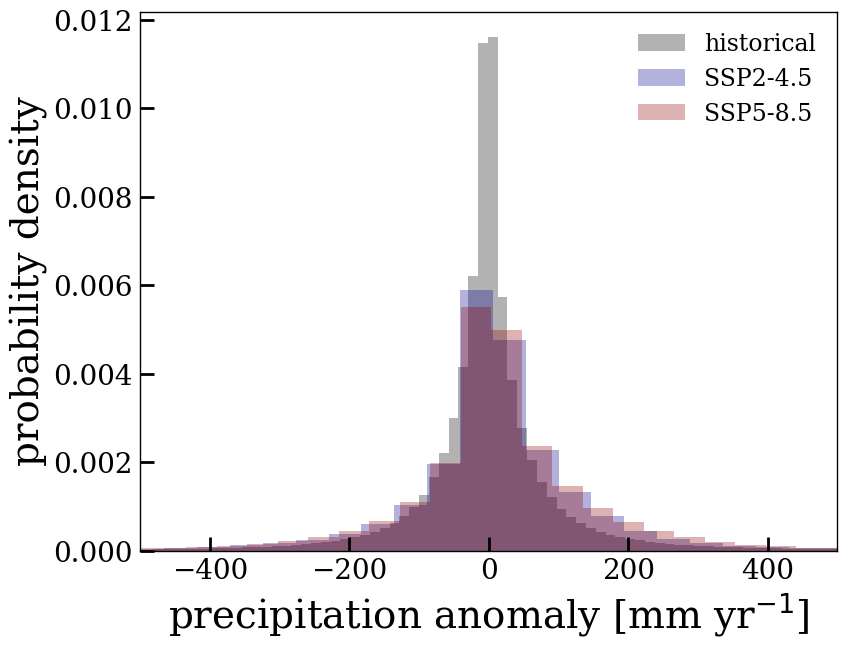

In [91]:
fig,ax= plt.subplots()
ax.hist(pr_anom245_per_year[:,35:-35,0:85,:].flatten(),bins = 300,alpha = 0.3, label = 'historical', density = True)
ax.hist(pr_anom245_per_year[:,35:-35,85:,:].flatten(),bins = 300,alpha = 0.3, label = 'SSP2-4.5', density = True, color = 'darkblue')
ax.hist(pr_anom585_per_year[:,35:-35,85:,:].flatten(),bins = 300,alpha = 0.3, label = 'SSP5-8.5', density = True, color = 'darkred')
ax.set_xlabel('precipitation anomaly [mm yr$^{-1}$]')
ax.set_ylabel('probability density')
plt.legend()
ax.set_xlim((-5e2,5e2))
# ax.set_xticks([-0.00005,0,0.00005])
plt.show()

In [ ]:
plotdata_sev = []
for starty in years:
    for i,dataset in enumerate([wd245,dwd245,dd245,d245,wd585,dwd585,dd585,d585]):
        if i <=3:
            tmp = swei245.copy()
        else: tmp = swei585.copy()
        tmp = tmp[:,:,starty:starty+50,:]
        tmp_mask = dataset[:,:,starty:starty+50,:]
        tmp[~tmp_mask] = np.nan
        tmp = np.nansum(tmp,axis = (2,3))
        tmp[(y>60)| (y < -60)] = np.nan
        tmp[snowmask] = np.nan
        plotdata_sev.append(tmp)

In [ ]:
## FREQUENCY ## 

proj = ccrs.NorthPolarStereo()
cmap = cm.roma_r
NORM = True
nm = 30
vmin = 0
vmax = 1

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
fig = plt.figure(figsize = (22,13))
## prep data
order = [0,8,16,20,
         1,9,17,21,
         2,10,18,22,
         3,11,19,23]

X,Y = np.meshgrid(x,y)
for i,val in enumerate(order):
    data2plot = plotdata[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)
    cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())

fig.tight_layout()
cax = plt.axes([0.25, -0.03, .5, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Frequency [-]',size=30)
## text
plt.text(-0.52,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(-0.52,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-0.52,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-0.52,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')

plt.text(-0.36,34.3,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(0.13,34.3,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(0.50,34.3,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(1.00,34.3,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()
fig.savefig(homedir + 'figures/fig4_val.jpg')

In [ ]:
## FREQUENCY DIFFERENCE MAPS ## 
proj = ccrs.NorthPolarStereo()
c_cmap = cm.roma_r
from matplotlib.colors import ListedColormap, BoundaryNorm
num_steps = 9
colors = c_cmap(np.linspace(0, 1, num_steps))
discrete_cmap = ListedColormap(colors)



NORM = True
nm = 30
vmin = 0
vmax = 1

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
fig = plt.figure(figsize = (22,13))
## prep data
order = [0,8,16,20,
         1,9,17,21,
         2,10,18,22,
         3,11,19,23]

baseline = plotdata[0]/(12*50)
X,Y = np.meshgrid(x,y)
for i,val in enumerate(order):
    data2plot = plotdata[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)
    if val > 4:
        data2plot = data2plot - baseline
        cmap = cm.vik
        vmin = -1
        vmax = 1
        cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)

    if val < 4:
        baseline = data2plot
        cmap = cm.bilbao
        cmap = cm.grayC
        vmin = 0
        vmax = 1
        cb1 = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)


    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())

fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03]) ## left, bottom, width, height
cax1 = plt.axes([0.02, -0.03, .175, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Change [-]',size=30)

cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Frequency [-]',size=30)


## text
x_base = -0.15
plt.text(x_base,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = 0.2
x_space = 1.4
plt.text(x_base ,34.1,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,34.1,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space , 34.1,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,34.1,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()

fig.savefig(homedir + 'figures/fig4_diff.jpg')

In [ ]:
## Print stats
order = [0,8,16,20,
         1,9,17,21,
         2,10,18,22,
         3,11,19,23]
##
# 1: all droughts frequency
print('hist baseline to ssp2-4.5 eoc all droughts : ', round(np.nanmean((plotdata[19]- plotdata[3])) /np.nanmean(plotdata[3]) * 100 ,2), 'percent, sd',
        round(np.nanstd((plotdata[19]- plotdata[3])/np.nanmean(plotdata[3])),2))
print('hist baseline to ssp5-8.5 eoc all droughts : ', round(np.nanmean((plotdata[23] - plotdata[3]))/np.nanmean(plotdata[3]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[23]- plotdata[3]) / np.nanmean(plotdata[3])),2))

# 1: all droughts frequency
print('hist baseline to ssp2-4.5 eoc all droughts : ', round(np.nanmean((plotdata[19]/(12*50)- plotdata[3]/(12*50))),2), '[-], sd',
        round(np.nanstd((plotdata[19]/(12*50)- plotdata[3]/(12*50))),2))
print('hist baseline to ssp5-8.5 eoc all droughts : ', round(np.nanmean((plotdata[23]/(12*50) - plotdata[3]/(12*50))) ,2), '[-], percent, sd', 
      round(np.nanstd((plotdata[23]/(12*50)- plotdata[3]/(12*50))),2))

### 

print('\nmodern droughts')
print('modern percent warm or warm and dry: ', round(np.nanmean((plotdata[8]+plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[8]+plotdata[9])/(plotdata[11]))* 100,2))

print('modern percent dry or warm and dry: ', round(np.nanmean((plotdata[10]+plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[10]+plotdata[9])/(plotdata[11]))* 100,2))

print('modern percent warm alone: ', round(np.nanmean((plotdata[8])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[8])/(plotdata[11]))* 100,2))

print('modern percent dry alone: ', round(np.nanmean((plotdata[10])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[9])/(plotdata[10]))* 100,2))

print('modern percent warm and dry alone: ', round(np.nanmean((plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[9])/(plotdata[11]))* 100,2))


# 2: how many were warm?
print('\nwarm stats')
print('historical percent warm or warm and dry: ', round(np.nanmean((plotdata[0]+plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[0] + plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent dry or warm and dry: ', round(np.nanmean((plotdata[2]+plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[2] + plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent warm alone: ', round(np.nanmean((plotdata[0])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[0])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent dry alone: ', round(np.nanmean((plotdata[2])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[2])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent warm and dry: ', round(np.nanmean((plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('eoc percent warm ssp2-4.5: ', round(np.nanmean((plotdata[16] + plotdata[17])/(plotdata[16] + plotdata[17] +plotdata[18] ))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[16] + plotdata[17])/(plotdata[16] + plotdata[17] +plotdata[18]))* 100,2))

print('eoc percent warm ssp5-8.5: ', round(np.nanmean((plotdata[20] + plotdata[21])/(plotdata[20] + plotdata[21] +plotdata[22] ))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[20] + plotdata[21])/(plotdata[20] + plotdata[21] +plotdata[22]))* 100,2))

print('\nfuture stats')

print('ssp245 eoc percent dry or warm and dry: ', round(np.nanmean((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2))
print('ssp585 eoc percent dry or warm and dry: ', round(np.nanmean((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2))

# 2 change in dry drought
print ('\ndry drought change')
print('hist baseline to ssp2-4.5 eoc dry droughts : ', round(np.nanmean((plotdata[18] - plotdata[2]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[18]- plotdata[2]) / np.nanmean(plotdata[2])),2))
print('hist baseline to ssp5-8.5 eoc dry droughts : ', round(np.nanmean((plotdata[22] - plotdata[2]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[22]- plotdata[2]) / np.nanmean(plotdata[2])),2))

print('modern to ssp2-4.5 eoc dry droughts : ', round(np.nanmean((plotdata[18] - plotdata[10]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[18]- plotdata[10]) / np.nanmean(plotdata[10])),2))
print('modern to ssp5-8.5 eoc dry droughts : ', round(np.nanmean((plotdata[22] - plotdata[10]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[22]- plotdata[10]) / np.nanmean(plotdata[10])),2))


print('modern - ssp245 eoc percent dry or warm and dry: ', 
      round(np.nanmean((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2))

print('modern - ssp585 eoc percent dry or warm and dry: ', 
      round(np.nanmean((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2))

#3: how much severity increase?
print('\nchange in severity')
print('hist baseline to ssp2-4.5 eoc all droughts sev :',  
      round((np.nanmean((plotdata_sev[19]- plotdata_sev[3])/12/50)),2) , 'SWEI value, ',
      round((np.nanstd((plotdata_sev[19]- plotdata_sev[3])/12/50)),2) , 'sd, ',
      round(np.nanmean((plotdata_sev[19]- plotdata_sev[3])) /np.nanmean(plotdata_sev[3]) * 100 ,2), 'percent, sd',
        round(np.nanstd((plotdata_sev[19]- plotdata_sev[3])/np.nanmean(plotdata_sev[3])),2))
print('hist baseline to ssp5-8.5 eoc all droughts sev: ', 
      round((np.nanmean((plotdata_sev[23]- plotdata_sev[3])/12/50)),2) , 'SWEI value, ',
      round((np.nanstd((plotdata_sev[23]- plotdata_sev[3])/12/50)),2) , 'sd, ',
      round(np.nanmean((plotdata_sev[23] - plotdata_sev[3]))/np.nanmean(plotdata_sev[3]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata_sev[23]- plotdata_sev[3]) / np.nanmean(plotdata_sev[3])),2))



In [ ]:
from scipy import stats
mask = ~np.isnan(plotdata[19])
res = stats.ttest_ind(plotdata[19][mask], plotdata[3][mask], 
                      equal_var=True)

display(res)


In [ ]:
## SEVERITY ##
proj = ccrs.NorthPolarStereo()
cmap = cm.acton
NORM = True
nm = 50
vmin = -np.e
vmax = 0

fig = plt.figure(figsize = (22,13))

for i,val in enumerate(order):
    data2plot = plotdata_sev[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)
    cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())
fig.tight_layout()
cax = plt.axes([0.25, -0.03, .5, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Severity [-]',size=30)
## textplt.text(-4.1,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(-4.1,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-4.1,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-4.1,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')

plt.text(-3.7,34.1,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(-2.4,34.1,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(-1.6, 34.1,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(-0.3,34.1,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')

plt.show()
fig.savefig(homedir + 'figures/fig5_val.jpg')

In [ ]:
## SEVERITY ##
proj = ccrs.NorthPolarStereo()
cmap = cm.acton
NORM = True
nm = 50
vmin = -np.e
vmax = 0

fig = plt.figure(figsize = (22,13))

baseline = plotdata_sev[0]/(12*50)
for i,val in enumerate(order):
    data2plot = plotdata_sev[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)

    if val > 4:
        data2plot = data2plot - baseline
        cmap = cm.bam
        vmin = -1
        vmax = 1
        cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    if val < 4:
        baseline = data2plot
        cmap = cm.grayC_r
        vmin = -np.e
        vmax = 0    
        cb1 = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)

    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())

fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03]) ## left, bottom, width, height
cax1 = plt.axes([0.01, -0.03, .2, 0.03])

cax.tick_params(axis="x", labelsize=25)
fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Change [-]',size=30)

cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Severity [-]',size=30)

## text
x_base = -3.1
plt.text(x_base,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = -2.1
y_top = 34.1
x_space = 3.3
plt.text(x_base,y_top,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,y_top,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space , y_top,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,y_top,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')

plt.show()
fig.savefig(homedir + 'figures/fig5_diff.jpg')
